# AH 溢价走势查看（Viewer）

用于查看你关心的 **A/H 两地上市股票** 的历史走势：

- **A 股价格**（CNY）
- **H 股价格（折算人民币）**：H 股收盘价（HKD）× `HKD→CNY`
- **AH 溢价**：
  - `premium = (A / H(CNY) - 1) * 100%`
  - 支持“复权价”口径（与本工程 `notebooks/ah_premium_strategy.ipynb` 一致：按各自 *最后交易日* 的 `adj_factor` 归一）

数据来源：本工程 `data/data.sqlite`（表：`daily_a`/`daily_h`/`adj_factor_a`/`adj_factor_h`/`fx_daily`）。

绘图风格参考 `refer/show_AH_premium.ipynb`（双 Y 轴：左轴价格、右轴溢价）。


In [1]:
# 环境与依赖
import _bootstrap  # noqa: F401 (adds src/ to sys.path)

from dataclasses import dataclass
from pathlib import Path
import datetime as dt

import numpy as np

# 可选：pandas / matplotlib（若导入失败，则 notebook 仍能运行到“查询/计算”层，但无法画图）
try:
    import pandas as pd
except Exception as e:  # pragma: no cover
    pd = None
    print('pandas unavailable:', repr(e))

try:
    import matplotlib
    import matplotlib.pyplot as plt

    matplotlib.rcParams['axes.unicode_minus'] = False

    # ---- 中文字体处理 ----
    # 现象：如果系统未安装中文字体，matplotlib 默认 DejaVu Sans 会缺字，出现
    # "Glyph xxxx missing from font" 警告，图里也会变成方块/乱码。
    import warnings
    from matplotlib import font_manager

    def _pick_cjk_font() -> str | None:
        candidates = [
            # Linux (often available via packages)
            'Noto Sans CJK SC',
            'Noto Sans CJK JP',
            'Source Han Sans SC',
            'WenQuanYi Zen Hei',
            'WenQuanYi Micro Hei',
            # Windows / macOS common
            'Microsoft YaHei',
            'SimHei',
            'PingFang SC',
            'Heiti SC',
            'Arial Unicode MS',
        ]
        available = {f.name for f in font_manager.fontManager.ttflist}
        for name in candidates:
            if name in available:
                return name
        # fuzzy fallback
        for name in sorted(available):
            if 'Noto Sans CJK' in name or 'Source Han Sans' in name or 'WenQuanYi' in name:
                return name
        return None

    CJK_FONT = _pick_cjk_font()
    if CJK_FONT:
        matplotlib.rcParams['font.sans-serif'] = [
            CJK_FONT,
            *matplotlib.rcParams.get('font.sans-serif', []),
        ]
        USE_CHINESE_LABELS = True
        print('matplotlib font:', CJK_FONT)
    else:
        # 没有中文字体：避免乱码，自动切英文标签；同时屏蔽缺字警告。
        USE_CHINESE_LABELS = False
        warnings.filterwarnings(
            'ignore',
            message=r'Glyph .* missing from font\(s\) DejaVu Sans\.',
        )
        print(
            'No CJK font found for matplotlib; fall back to English labels. '            "To enable Chinese labels, install a CJK font (e.g. Ubuntu/Debian: 'apt-get install fonts-noto-cjk')."
        )

except Exception as e:  # pragma: no cover
    matplotlib = None
    plt = None
    USE_CHINESE_LABELS = True
    print('matplotlib unavailable:', repr(e))

from qs.sqlite_utils import connect_sqlite, table_exists

LABELS_CN = {
    'a_price': 'A股价格 (RMB)',
    'h_price': 'H股价格 (折算RMB)',
    'a_ma': 'A股 {n}日均线',
    'h_ma': 'H股 {n}日均线',
    'price_ylabel': '价格 (人民币)',
    'premium': 'AH 溢价率 (%)',
    'premium_adj_tag': ' 复权口径',
    'premium_ma': '溢价率 {n}日均线',
    'date_xlabel': '日期',
    'adjusted_tag': ' 复权',
    'title': '{name} ({a} / {h})：A/H 价格与溢价（{n}日趋势）',
}

LABELS_EN = {
    'a_price': 'A price (CNY)',
    'h_price': 'H price (CNY)',
    'a_ma': 'A {n}D MA',
    'h_ma': 'H {n}D MA',
    'price_ylabel': 'Price (CNY)',
    'premium': 'AH premium (%)',
    'premium_adj_tag': ' (adj)',
    'premium_ma': 'Premium {n}D MA',
    'date_xlabel': 'Date',
    'adjusted_tag': ' (adj)',
    'title': 'AH Price & Premium ({n}D) - {a} / {h}',
}

LABELS = LABELS_CN if USE_CHINESE_LABELS else LABELS_EN


No CJK font found for matplotlib; fall back to English labels. To enable Chinese labels, install a CJK font (e.g. Ubuntu/Debian: 'apt-get install fonts-noto-cjk').


In [2]:
# 参数
DB_PATH = _bootstrap.RAW_DB_PATH
PAIRS_CSV = _bootstrap.DATA_DIR / 'ah_codes.csv'

START_DATE = '20170101'
END_DATE = None  # e.g. '20251231'

# 价格/溢价口径
PLOT_USE_ADJUSTED_PRICES = True
PREMIUM_USE_ADJUSTED = True

# 对齐方式：
# - True: 按 A+H 联合交易日历 reindex，并对价格/汇率做 forward-fill（更连续，但包含“非交易日沿用上一交易日价格”）
# - False: 只在各自有数据的日期上显示；溢价会出现缺口
FFILL_TO_CALENDAR = True

ROLL_WINDOW = 60  # 趋势线窗口（日）

if not DB_PATH.exists():
    raise FileNotFoundError(f'Missing DB: {DB_PATH} (run fetch/sync scripts first)')
if pd is None:
    raise RuntimeError('pandas is required for this viewer notebook')

print('DB:', DB_PATH)
print('pairs:', PAIRS_CSV)


DB: /root/dev/quant_strategy_v2/data/data.sqlite
pairs: /root/dev/quant_strategy_v2/data/ah_codes.csv


In [3]:
# 数据结构

@dataclass(frozen=True)
class AHPair:
    name: str
    cn_code: str
    hk_code: str


def _read_pairs(csv_path: Path = PAIRS_CSV) -> 'pd.DataFrame':
    df = pd.read_csv(csv_path)
    # 兼容历史列名：有的文件 hk_code，有的用 c
    if 'hk_code' not in df.columns and 'c' in df.columns:
        df = df.rename(columns={'c': 'hk_code'})
    for col in ['name', 'cn_code', 'hk_code']:
        if col not in df.columns:
            raise ValueError(f'ah_codes.csv missing column: {col}')
    df = df[['name', 'cn_code', 'hk_code']].copy()
    df['name'] = df['name'].astype(str).str.strip()
    df['cn_code'] = df['cn_code'].astype(str).str.strip()
    df['hk_code'] = df['hk_code'].astype(str).str.strip()
    return df


PAIRS_DF = _read_pairs()
print('pairs:', len(PAIRS_DF))
PAIRS_DF.head()


pairs: 150


,name,cn_code,hk_code
0,第一拖拉机股份,601038.SH,00038.HK
1,四川成渝高速公路,601107.SH,00107.HK
2,青岛啤酒股份,600600.SH,00168.HK
3,江苏宁沪高速公路,600377.SH,00177.HK
4,京城机电股份,600860.SH,00187.HK


In [4]:
# SQLite -> pandas helpers

def _pad_start_date(date_str: str, pad_days: int = 40) -> str:
    d = dt.datetime.strptime(date_str, '%Y%m%d').date()
    return (d - dt.timedelta(days=pad_days)).strftime('%Y%m%d')


def _load_base_adj_factor(con, table: str, ts_code: str) -> float:
    if not table_exists(con, table):
        return 1.0
    row = con.execute(
        f"SELECT adj_factor FROM {table} WHERE ts_code=? ORDER BY trade_date DESC LIMIT 1",
        [ts_code],
    ).fetchone()
    if not row or row[0] in (None, 0, 0.0, ''):
        return 1.0
    base = float(row[0])
    return base if base != 0 else 1.0


def _load_price_series(
    con,
    *,
    price_table: str,
    adj_table: str,
    ts_code: str,
    start_date: str,
    end_date: str | None,
) -> 'pd.DataFrame':
    where = ['p.ts_code = ?', 'p.trade_date >= ?']
    params: list[object] = [ts_code, start_date]
    if end_date:
        where.append('p.trade_date <= ?')
        params.append(end_date)

    sql = f"""
    SELECT p.trade_date,
           p.close AS close,
           COALESCE(af.adj_factor, 1.0) AS adj_factor
    FROM {price_table} p
    LEFT JOIN {adj_table} af USING (ts_code, trade_date)
    WHERE {' AND '.join(where)}
    ORDER BY p.trade_date
    """

    df = pd.read_sql_query(sql, con, params=params)
    if df.empty:
        return df
    df['trade_date'] = pd.to_datetime(df['trade_date'].astype(str))
    df = df.set_index('trade_date').sort_index()
    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df['adj_factor'] = pd.to_numeric(df['adj_factor'], errors='coerce').fillna(1.0)

    base = _load_base_adj_factor(con, adj_table, ts_code)
    df['close_adj'] = df['close'] * (df['adj_factor'] / base)
    return df[['close', 'close_adj', 'adj_factor']]


def _load_hk2cn_series(
    con,
    *,
    start_date: str,
    end_date: str | None,
) -> 'pd.Series':
    # 用 USD/CNH 与 USD/HKD 交叉得到 HKD->CNY；并在日历上 forward-fill（等价“取最近不晚于当日的可用 FX”）
    where = ['trade_date >= ?']
    params: list[object] = [start_date]
    if end_date:
        where.append('trade_date <= ?')
        params.append(end_date)

    sql = f"""
    SELECT trade_date,
           MAX(CASE WHEN ts_code='USDCNH.FXCM' THEN (bid_close+ask_close)/2 END) AS usd_cnh_mid,
           MAX(CASE WHEN ts_code='USDHKD.FXCM' THEN (bid_close+ask_close)/2 END) AS usd_hkd_mid
    FROM fx_daily
    WHERE ts_code IN ('USDCNH.FXCM','USDHKD.FXCM')
      AND {' AND '.join(where)}
    GROUP BY trade_date
    HAVING COUNT(DISTINCT ts_code)=2
    ORDER BY trade_date
    """

    fx = pd.read_sql_query(sql, con, params=params)
    if fx.empty:
        return pd.Series(dtype=float, name='hk2cn')

    fx['trade_date'] = pd.to_datetime(fx['trade_date'].astype(str))
    fx = fx.set_index('trade_date').sort_index()
    usd_cnh = pd.to_numeric(fx['usd_cnh_mid'], errors='coerce')
    usd_hkd = pd.to_numeric(fx['usd_hkd_mid'], errors='coerce')
    hk2cn = usd_cnh / usd_hkd
    hk2cn.name = 'hk2cn'
    return hk2cn


In [5]:
# 核心：加载单个 A/H 标的的历史（价格 + 溢价）

def resolve_pair(key: str, pairs_df: 'pd.DataFrame' = PAIRS_DF) -> AHPair:
    k = str(key).strip()

    # exact match by name
    hit = pairs_df[pairs_df['name'] == k]
    if len(hit) == 1:
        r = hit.iloc[0]
        return AHPair(name=str(r['name']), cn_code=str(r['cn_code']), hk_code=str(r['hk_code']))

    # exact match by code
    hit = pairs_df[(pairs_df['cn_code'] == k) | (pairs_df['hk_code'] == k)]
    if len(hit) == 1:
        r = hit.iloc[0]
        return AHPair(name=str(r['name']), cn_code=str(r['cn_code']), hk_code=str(r['hk_code']))

    # fuzzy contains by name
    hit = pairs_df[pairs_df['name'].str.contains(k, na=False)]
    if len(hit) == 1:
        r = hit.iloc[0]
        return AHPair(name=str(r['name']), cn_code=str(r['cn_code']), hk_code=str(r['hk_code']))

    if len(hit) > 1:
        raise ValueError(f"Ambiguous key={k!r}, candidates={hit['name'].head(10).tolist()} (showing up to 10)")
    raise ValueError(f"Unknown A/H pair key: {k!r} (try exact name / cn_code / hk_code)")


def load_ah_pair_history(
    key: str,
    *,
    start_date: str = START_DATE,
    end_date: str | None = END_DATE,
    plot_use_adjusted_prices: bool = PLOT_USE_ADJUSTED_PRICES,
    premium_use_adjusted: bool = PREMIUM_USE_ADJUSTED,
    ffill_to_calendar: bool = FFILL_TO_CALENDAR,
) -> 'pd.DataFrame':
    pair = resolve_pair(key)

    con = connect_sqlite(DB_PATH, read_only=True)
    try:
        a = _load_price_series(
            con,
            price_table='daily_a',
            adj_table='adj_factor_a',
            ts_code=pair.cn_code,
            start_date=start_date,
            end_date=end_date,
        )
        h = _load_price_series(
            con,
            price_table='daily_h',
            adj_table='adj_factor_h',
            ts_code=pair.hk_code,
            start_date=start_date,
            end_date=end_date,
        )

        if a.empty or h.empty:
            raise ValueError(f'No price data for pair: {pair}')

        calendar = a.index.union(h.index).sort_values()

        fx_start = _pad_start_date(min(start_date, calendar.min().strftime('%Y%m%d')))
        hk2cn = _load_hk2cn_series(con, start_date=fx_start, end_date=end_date)

    finally:
        con.close()

    df = pd.DataFrame(index=calendar)
    df['p_a'] = a['close']
    df['p_a_adj'] = a['close_adj']
    df['p_hk'] = h['close']
    df['p_hk_adj'] = h['close_adj']

    # FX：取最近不晚于当日的可用值
    df['hk2cn'] = hk2cn.reindex(df.index).ffill()

    if ffill_to_calendar:
        df[['p_a', 'p_a_adj', 'p_hk', 'p_hk_adj']] = df[['p_a', 'p_a_adj', 'p_hk', 'p_hk_adj']].ffill()

    df['p_hk_cn'] = df['p_hk'] * df['hk2cn']
    df['p_hk_adj_cn'] = df['p_hk_adj'] * df['hk2cn']

    df['AH_premium'] = (df['p_a'] / df['p_hk_cn'] - 1.0) * 100.0
    df['AH_premium_adj'] = (df['p_a_adj'] / df['p_hk_adj_cn'] - 1.0) * 100.0

    # 默认展示口径
    if plot_use_adjusted_prices:
        df['p_a_plot'] = df['p_a_adj']
        df['p_hk_plot_cn'] = df['p_hk_adj_cn']
    else:
        df['p_a_plot'] = df['p_a']
        df['p_hk_plot_cn'] = df['p_hk_cn']

    df['premium_plot'] = df['AH_premium_adj'] if premium_use_adjusted else df['AH_premium']

    df.attrs['pair'] = pair
    df.attrs['start_date'] = start_date
    df.attrs['end_date'] = end_date
    df.attrs['plot_use_adjusted_prices'] = plot_use_adjusted_prices
    df.attrs['premium_use_adjusted'] = premium_use_adjusted
    df.attrs['ffill_to_calendar'] = ffill_to_calendar
    return df


# quick sanity (single name)
pair0 = resolve_pair('招商银行')
print(pair0)


AHPair(name='招商银行', cn_code='600036.SH', hk_code='03968.HK')


In [6]:
# 绘图（参考 refer/show_AH_premium.ipynb：双轴 + 趋势线）

def plot_ah_price_premium(
    key: str,
    *,
    start_date: str = START_DATE,
    end_date: str | None = END_DATE,
    roll_window: int = ROLL_WINDOW,
    save: bool = False,
    dpi: int = 200,
    out_path: str | None = None,
    plot_use_adjusted_prices: bool = PLOT_USE_ADJUSTED_PRICES,
    premium_use_adjusted: bool = PREMIUM_USE_ADJUSTED,
    ffill_to_calendar: bool = FFILL_TO_CALENDAR,
):
    if plt is None:
        raise RuntimeError('matplotlib is required for plotting')

    df = load_ah_pair_history(
        key,
        start_date=start_date,
        end_date=end_date,
        plot_use_adjusted_prices=plot_use_adjusted_prices,
        premium_use_adjusted=premium_use_adjusted,
        ffill_to_calendar=ffill_to_calendar,
    )
    pair: AHPair = df.attrs['pair']

    # 过滤起止日期
    if start_date:
        df = df[df.index >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df.index <= pd.to_datetime(end_date)]

    # 趋势线
    df['p_a_roll'] = df['p_a_plot'].rolling(roll_window, min_periods=5).mean()
    df['p_hk_roll'] = df['p_hk_plot_cn'].rolling(roll_window, min_periods=5).mean()
    df['prem_roll'] = df['premium_plot'].rolling(roll_window, min_periods=5).mean()

    fig, ax_price = plt.subplots(figsize=(14, 6))

    ax_price.plot(
        df.index,
        df['p_a_plot'],
        label=LABELS['a_price'] + (LABELS['adjusted_tag'] if plot_use_adjusted_prices else ''),
        linewidth=1.4,
        color='tab:blue',
        alpha=0.3,
    )
    ax_price.plot(
        df.index,
        df['p_hk_plot_cn'],
        label=LABELS['h_price'] + (LABELS['adjusted_tag'] if plot_use_adjusted_prices else ''),
        linewidth=1.4,
        color='tab:orange',
        alpha=0.3,
    )

    ax_price.plot(
        df.index,
        df['p_a_roll'],
        label=LABELS['a_ma'].format(n=roll_window),
        linewidth=2,
        color='tab:blue',
    )
    ax_price.plot(
        df.index,
        df['p_hk_roll'],
        label=LABELS['h_ma'].format(n=roll_window),
        linewidth=2,
        color='tab:orange',
    )

    ax_price.set_ylabel(LABELS['price_ylabel'], fontsize=12)
    ymax_price = float(np.nanmax([df['p_a_plot'].max(), df['p_hk_plot_cn'].max()])) * 1.05
    if np.isfinite(ymax_price) and ymax_price > 0:
        ax_price.set_ylim(0, ymax_price)

    ax_prem = ax_price.twinx()
    ax_prem.plot(
        df.index,
        df['premium_plot'],
        label=LABELS['premium'] + (LABELS['premium_adj_tag'] if premium_use_adjusted else ''),
        linewidth=1.4,
        linestyle='--',
        color='darkred',
        alpha=0.3,
    )
    ax_prem.plot(
        df.index,
        df['prem_roll'],
        label=LABELS['premium_ma'].format(n=roll_window),
        linewidth=2,
        linestyle='--',
        color='darkred',
    )

    ax_prem.axhline(0, linestyle=':', linewidth=0.8, color='gray')
    ax_prem.set_ylabel(LABELS['premium'], fontsize=12)
    prem_max = float(np.nanmax(np.abs(df['premium_plot'])))
    if np.isfinite(prem_max) and prem_max > 0:
        prem_max = float(np.ceil(prem_max * 1.05))
        ax_prem.set_ylim(-prem_max, prem_max)

    title_name = pair.name if USE_CHINESE_LABELS else f'{pair.cn_code} / {pair.hk_code}'
    title = LABELS['title'].format(
        name=title_name,
        a=pair.cn_code,
        h=pair.hk_code,
        n=roll_window,
    )
    if ffill_to_calendar:
        title += '  [FFILL]'
    plt.title(title, fontsize=15)
    ax_price.set_xlabel(LABELS['date_xlabel'], fontsize=12)

    # 合并图例
    hl, ll = ax_price.get_legend_handles_labels()
    hr, lr = ax_prem.get_legend_handles_labels()
    ax_price.legend(hl + hr, ll + lr, loc='upper left', fontsize=9, ncol=2)

    fig.tight_layout()

    last = df.dropna(subset=['p_a_plot', 'p_hk_plot_cn', 'premium_plot']).iloc[-1]
    print(
        f"{pair.name} latest @ {last.name.date()} | A={last['p_a_plot']:.2f} | H(CNY)={last['p_hk_plot_cn']:.2f} | premium={last['premium_plot']:.2f}%"
    )

    if save:
        if out_path is None:
            safe_name = pair.name if USE_CHINESE_LABELS else f'{pair.cn_code}_{pair.hk_code}'
            out_path = f"{safe_name}_AH_price_premium.png"
        fig.savefig(out_path, dpi=dpi)

    plt.show()


招商银行 latest @ 2026-02-04 | A=39.01 | H(CNY)=42.15 | premium=-7.45%


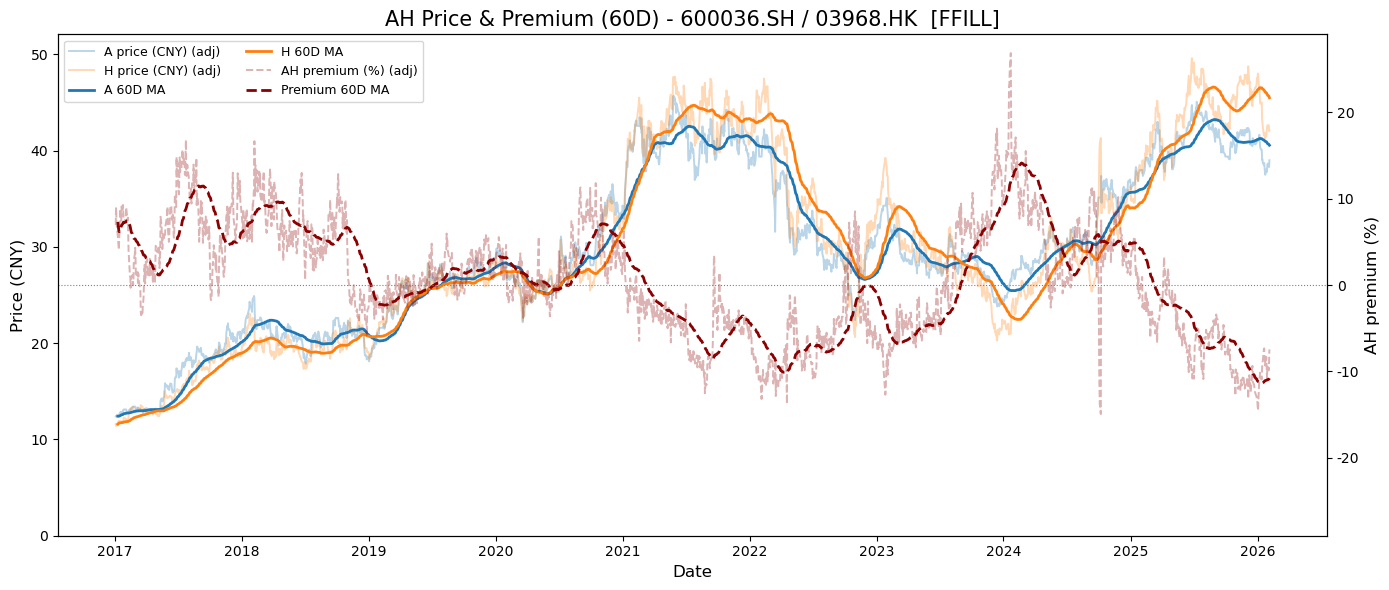

中国平安 latest @ 2026-02-04 | A=67.40 | H(CNY)=63.94 | premium=5.42%


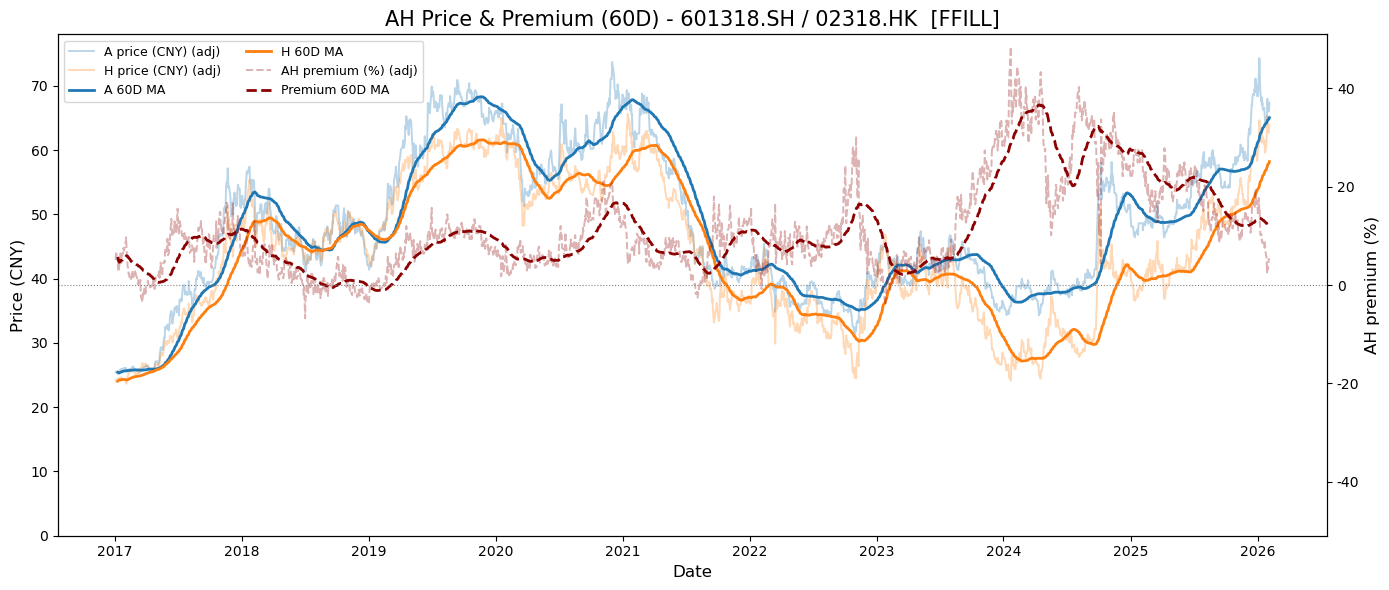

中信证券 latest @ 2026-02-04 | A=28.38 | H(CNY)=25.98 | premium=9.23%


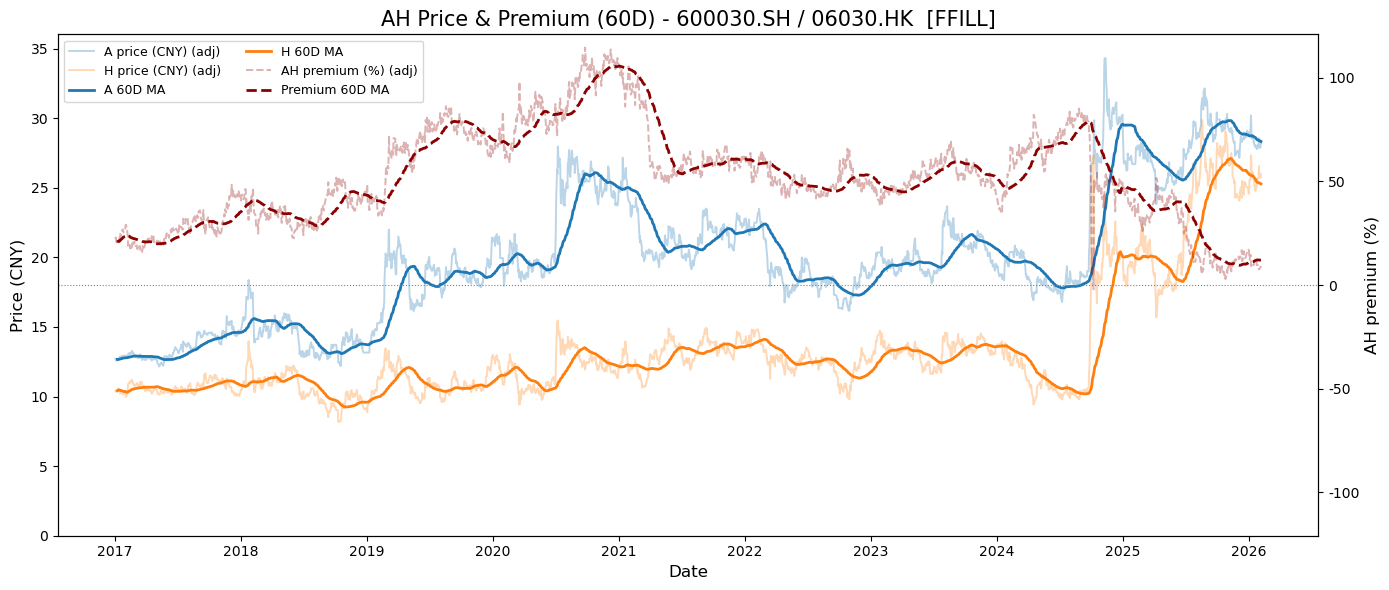

In [ ]:
# 使用示例：批量绘制你关心的标的

WATCHLIST = [
    '招商银行',
    '中国平安',
    '中信证券',
    '中国人寿',
    '浙江世宝',
]

for name in WATCHLIST:
    plot_ah_price_premium(name)


In [8]:
# 可选：下拉选择（需要 ipywidgets）
try:
    import ipywidgets as widgets
    from IPython.display import display

    dd = widgets.Dropdown(
        options=sorted(PAIRS_DF['name'].unique().tolist()),
        value='招商银行',
        description='A/H：',
        layout=widgets.Layout(width='50%'),
    )

    def _on_change(change):
        if change.get('name') == 'value':
            plot_ah_price_premium(change['new'])

    dd.observe(_on_change, names='value')
    display(dd)
except Exception as e:  # pragma: no cover
    print('ipywidgets unavailable:', repr(e))


ipywidgets unavailable: ModuleNotFoundError("No module named 'ipywidgets'")
